In [3]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

seed = 2023 # DO NOT CHANGE!

In [4]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data

In [5]:
PBMC = sp.read_h5ad("../pbmc_multiome.h5ad")

In [6]:
print(f"The data has {PBMC.n_obs} observations and {PBMC.n_vars} features.")

The data has 9641 observations and 19607 features.


In [7]:
PBMC

AnnData object with n_obs × n_vars = 9641 × 19607
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'RNA_snn_res.0.5', 'seurat_clusters', 'predicted.id', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.NK', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.score.Treg', 'prediction.score.Plasmablast', 'prediction.score.CD4.TEM', 'prediction.score.cDC2', 'prediction.score.NK.Proliferating', 'prediction.score.ASDC', 'prediction.score.HSPC', 'prediction.score.Plat

In [8]:
PBMC.X

<9641x19607 sparse matrix of type '<class 'numpy.float64'>'
	with 73296936 stored elements in Compressed Sparse Row format>

# Data Filtering + Train/Test Split

In [9]:
cutoff = 0.001

cell_types, type_numbers = np.unique(PBMC.obs['predicted.id'], return_counts=True)
bad_types = cell_types[type_numbers / len(PBMC.obs['predicted.id'])<cutoff]
print(bad_types)

bad_types_mask = np.invert(np.isin(PBMC.obs['predicted.id'], bad_types))
X = PBMC.X[bad_types_mask]
Y = PBMC.obs['predicted.id'][bad_types_mask]

print(Y.shape)

['ASDC' 'CD4 Proliferating' 'CD8 Proliferating' 'CD8 TCM' 'HSPC' 'ILC'
 'NK Proliferating' 'NK_CD56bright' 'Plasmablast' 'cDC1' 'dnT' 'gdT']
(9510,)


9510 number of cells, with 15 total cell types


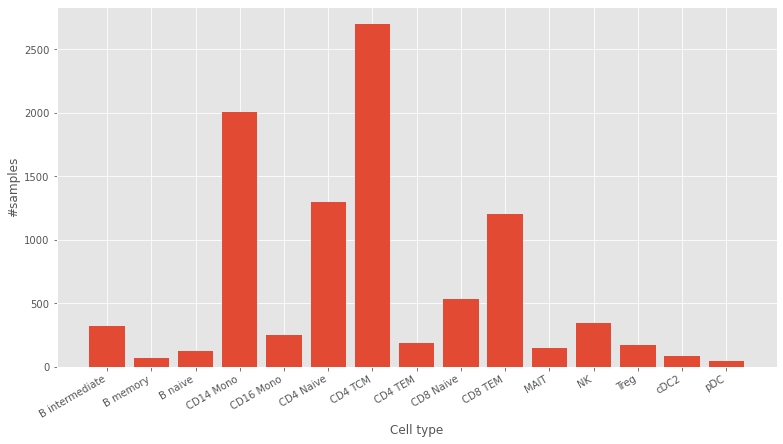

In [10]:
cell_types, type_numbers = np.unique(Y, return_counts=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(type_numbers)} number of cells, with {len(cell_types)} total cell types")
ax.bar(list(map(str, cell_types)), type_numbers)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

n_train = X_train.shape[0]
n_test = X_test.shape[0]
print(f"{n_train} train samples\n{n_test} test samples\n{n_train/(n_train+n_test)*100:.2f}% of samples used for training")

7132 train samples
2378 test samples
74.99% of samples used for training


# Model training

In [ ]:
n_folds = 5 # change?

cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = seed)

param_grid = {
    'min_samples_split': [2,10,20]
}

rf = RandomForestClassifier()
gridsearch = GridSearchCV(rf,param_grid, n_jobs=-1, cv=cv, verbose=5, 
                          return_train_score=True)

gridsearch.fit(X_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print(f'Average training accuracy across folds: {train_score:.3}')
print(f'Average validation accuracy across folds: {validation_score:.3}')

print(f'Best hyperparams: {gridsearch.best_params_}')

In [ ]:
# save best model
with open('PBMC_RF.pkl','wb') as f:
    pickle.dump(gridsearch.best_estimator_,f)